In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(0, os.path.join("..", "paper-2"))
from orion_util import get_lines, get_params

sys.path.insert(0, os.path.join("..", "paper-2", "data"))
from helpers import prepare_data, select_envs

sys.path.insert(0, os.path.join("..", "paper-1"))
from pdr_util import simulate, pdr_model, get_physical_env

In [2]:
def convert_unit(T, nu, dv):
    """
    [T]: K
    [nu]: Hz
    [dv]: km.s^-1
    """
    nu = 1e9 * nu
    kb = 1.380_649e-23 # m^2.kg.s^-2.K^-1
    c = 299_792_458 # m.s^-1
    return (2 * 1e6 * (nu/c)**3 * kb) * T * dv

def g0_to_radm(g0):
    return g0 / (1.27/2)

dv = 0.5

In [3]:
df_ref = pd.read_csv(
    os.path.join("..", "paper-1", "data", "raw", "emir_lines_selection", "emir_table_filtered.csv")
)
df_ref = df_ref.set_index("line_id")

df_ref.head()

,EMIR band,freq,Calibration error (%),molecule,per99_intensity,Noise RMS (K) [1 min],"Noise RMS (Mathis units, log10) [1 min]",Noise RMS (K) [0.4 min],"Noise RMS (Mathis units, log10) [0.4 min]",SNR (per99),"SNR (per99, dB)"
line_id,,,,,,,,,,,
hcn_j1_f2__j0_f1,E090,88.631747,5.0,hcn,-8.327269,0.440627,-9.803540,0.696692,-9.604570,18.936567,12.773012
hcop_j1__j0,E090,89.180730,5.0,hcop,-7.559371,0.438854,-9.797246,0.693889,-9.598276,109.371688,20.389049
hnc_j1__j0,E090,90.663573,5.0,hnc,-8.274138,0.434673,-9.779917,0.687279,-9.580947,20.267905,13.068089
cs_j2__j1,E090,98.161313,5.0,cs,-7.119470,0.424535,-9.686644,0.671248,-9.487674,233.455508,23.682041
c_18o_j1__j0,E090,109.788146,5.0,c_18o,-7.623276,0.477504,-9.489735,0.755001,-9.290765,46.503830,16.674887


In [4]:
line_names, param_names = get_lines(), get_params()
lines, params = prepare_data(line_names, param_names)

lines, params = select_envs(lines, params, ["horsehead"])

line_names, param_names

(['12cn10',
  '12co10',
  '12cs21',
  '13co10',
  '32so21',
  'c3h2',
  'c17o10',
  'c18o10',
  'cch10',
  'ch3oh21',
  'h2co',
  'h13cop10',
  'hcn10',
  'hcop10',
  'hnc10',
  'n2hp10'],
 ['av', 'g0', 'tkin', 'nh2', 'density'])

In [5]:
av = params[:, param_names.index("av")]
radm = g0_to_radm(params[:, param_names.index("g0")])
P =  1e5 * np.ones_like(av)
angle = np.zeros_like(av)

inputs = {
    "Avmax": av,
    "radm": radm,
    "P": P,
    "angle": angle
}

obs_time = 4 * 0.1
kappa = 0.25

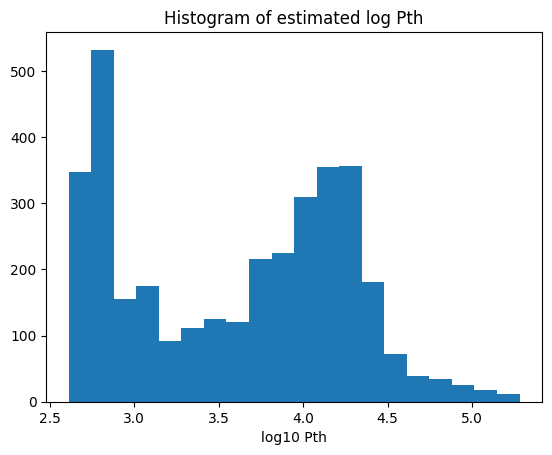

In [6]:
plt.hist(np.log10(params[:, param_names.index("density")] * params[:, param_names.index("tkin")]), bins=20)

plt.xlabel("log10 Pth")
plt.title("Histogram of estimated log Pth")

plt.savefig("P_hist.png")
plt.show()

In [7]:
df = pdr_model(
    inputs,
    obs_time=obs_time,
    noise=True,
    kappa=kappa
)

df.head(10)

,P,radm,Avmax,kappa,hcn_j1_f2__j0_f1,hcop_j1__j0,hnc_j1__j0,cs_j2__j1,c_18o_j1__j0,13c_o_j1__j0,...,13c_o_j3__j2,cn_n3_j2d5__n2_j1d5,cn_n3_j3d5__n2_j2d5,cs_j7__j6,co_v0_j3__v0_j2,c2h_n4d0_j4d5_f5d0__n3d0_j3d5_f4d0,hcop_j4__j3,c_el3p_j1__el3p_j0,c_el3p_j2__el3p_j1,cp_el2p_j3_2__el2p_j1_2
0,100000.0,122.839229,4.779380,0.25,7.062434e-10,3.959580e-10,3.397642e-10,6.898643e-10,2.182675e-10,2.623086e-09,...,-2.591831e-08,1.066350e-08,6.269808e-08,8.425198e-08,7.076247e-07,-7.802486e-08,-2.141573e-07,1.057228e-06,-2.130784e-07,2.701934e-05
1,100000.0,120.022275,5.058357,0.25,8.241423e-11,2.899483e-10,2.311675e-11,-2.872484e-11,9.890966e-11,3.774902e-09,...,1.778147e-07,2.767191e-08,-4.362977e-08,-3.361932e-08,6.384572e-07,7.015536e-09,2.580175e-09,6.684519e-07,2.407800e-06,6.251701e-05
2,100000.0,119.264568,5.444949,0.25,-1.996530e-10,4.999607e-10,5.008375e-10,5.231636e-10,5.919127e-10,4.559911e-09,...,-1.058670e-07,-3.813645e-09,-5.386700e-08,1.254044e-08,5.871264e-07,-1.300544e-07,-6.155572e-08,6.127429e-07,1.027590e-06,1.522584e-05
3,100000.0,116.413472,5.984659,0.25,1.687892e-10,4.937920e-10,1.959860e-10,5.592010e-10,1.042093e-09,5.215837e-09,...,-2.287092e-07,-6.459145e-08,3.398878e-08,5.503647e-08,6.301552e-07,-8.566402e-09,-5.187238e-08,7.871120e-07,3.377748e-06,-2.393653e-07
4,100000.0,117.164858,6.592308,0.25,3.840599e-10,8.693665e-10,1.514003e-10,1.127568e-09,9.147452e-10,4.694374e-09,...,7.958246e-08,5.088441e-08,3.909656e-08,4.183278e-08,5.547627e-07,-4.767862e-08,-7.665826e-08,1.046133e-06,1.346044e-06,1.961214e-05
5,100000.0,119.283586,7.320707,0.25,-7.780631e-11,8.981527e-10,-2.566089e-10,1.734648e-09,9.761762e-10,6.163970e-09,...,-8.130527e-08,-4.476485e-08,5.441740e-08,9.198827e-08,8.036209e-07,2.537427e-08,8.592162e-08,7.893858e-07,3.337942e-06,-2.427612e-05
6,100000.0,119.591199,8.264463,0.25,1.392236e-10,1.831926e-09,3.732432e-10,2.477697e-09,1.211706e-09,6.901865e-09,...,-1.807609e-08,-1.043954e-07,8.189833e-08,1.078130e-07,7.314997e-07,-1.447387e-07,-1.013921e-07,6.000989e-07,7.171267e-07,7.960625e-05
7,100000.0,116.767619,8.641262,0.25,1.883633e-10,1.785440e-09,1.228417e-10,3.225410e-09,7.897677e-10,6.243244e-09,...,2.360323e-07,4.018242e-08,1.138043e-07,3.089868e-08,6.699768e-07,-2.493903e-08,-1.941122e-08,8.797716e-07,7.209236e-08,2.846576e-05
8,100000.0,113.084247,8.563123,0.25,-2.107329e-10,1.585412e-09,2.924635e-10,3.110480e-09,1.991020e-09,6.485255e-09,...,5.963546e-09,-5.980112e-08,-3.335176e-08,-2.151405e-08,6.182631e-07,8.909181e-08,9.888939e-08,1.264701e-06,-5.521498e-07,-6.333990e-05
9,100000.0,112.969671,8.032965,0.25,-2.958848e-10,1.589483e-09,-1.170883e-10,2.058736e-09,1.397424e-09,5.573270e-09,...,1.074997e-07,2.830804e-08,-4.472030e-08,-8.913481e-09,7.644474e-07,5.802386e-08,-1.355834e-07,6.381258e-07,4.261388e-06,4.014532e-05


In [8]:
def make_plot(
    linename_model,
    linename_data
):

    nu = df_ref.at[linename_model, "freq"]
    rms = df_ref.at[linename_model, "Noise RMS (K) [1 min]"]
    rms /= obs_time**0.5

    rms = convert_unit(
        rms,
        nu=nu,
        dv=dv
    )
    x = convert_unit(
        lines[:, line_names.index(linename_data)],
        nu=nu,
        dv=dv
    )

    y = df[linename_model]

    #

    plt.figure(dpi=150)

    plt.scatter(
        x, y, s=1
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Data")
    plt.ylabel("PDR model")
    plt.title(f"{linename_data}, {linename_model}")

    xlim = [
        min(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0]),
        max(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]),
    ]

    plt.gca().set_box_aspect(1)
    plt.xlim(xlim); plt.ylim(xlim)
    plt.grid()

    plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), color="tab:red")
    plt.axvline(rms, linestyle="--", color="black")
    plt.axhline(rms, linestyle="--", color="black")

    plt.savefig(linename_data, bbox_inches="tight")
    plt.show()

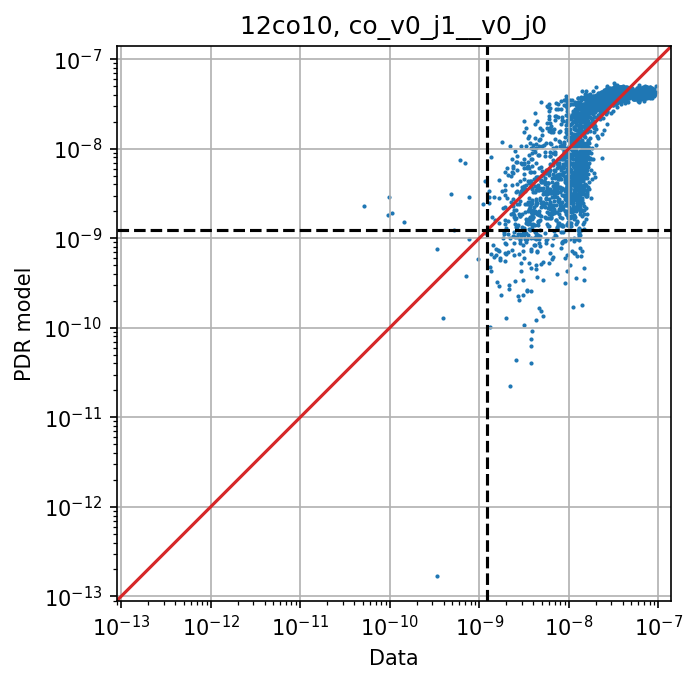

In [9]:
linename_model = "co_v0_j1__v0_j0"
linename_data = "12co10"

make_plot(linename_model, linename_data)

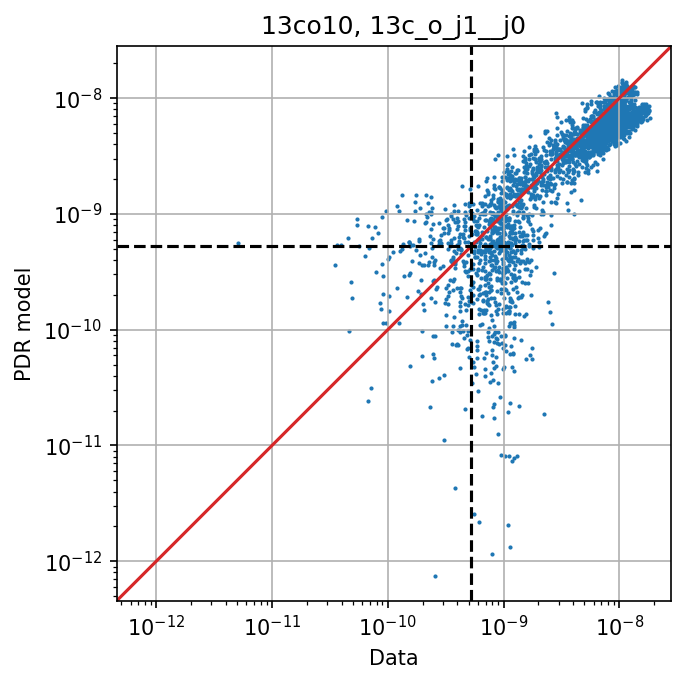

In [10]:
linename_model = "13c_o_j1__j0"
linename_data = "13co10"

make_plot(linename_model, linename_data)

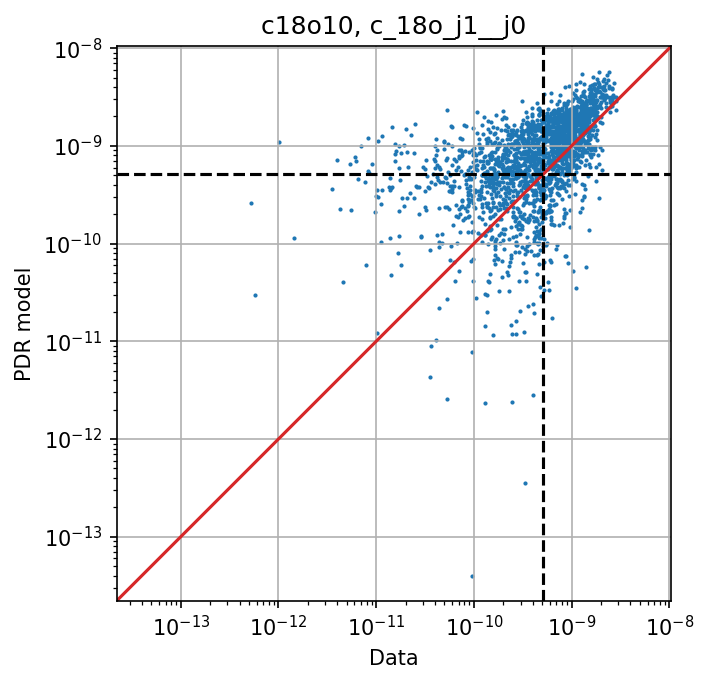

In [11]:
linename_model = "c_18o_j1__j0"
linename_data = "c18o10"

make_plot(linename_model, linename_data)

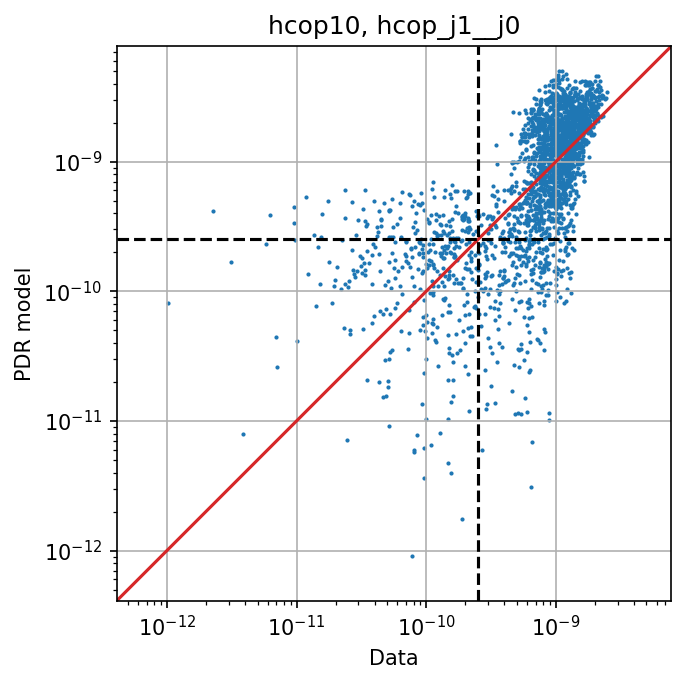

In [12]:
linename_model = "hcop_j1__j0"
linename_data = "hcop10"

make_plot(linename_model, linename_data)